In [1]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import optuna
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

In [2]:
df_species = pd.read_csv('./dataset/species_dataset.csv')

In [3]:
df_species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   species_id          600 non-null    object 
 1   body_mass_kg        600 non-null    float64
 2   num_legs            600 non-null    int64  
 3   has_wings           600 non-null    int64  
 4   tail_length_cm      600 non-null    float64
 5   diet_type           600 non-null    object 
 6   eye_count           600 non-null    int64  
 7   skin_type           600 non-null    object 
 8   nocturnal           600 non-null    int64  
 9   avg_lifespan_years  600 non-null    float64
 10  has_venom           600 non-null    int64  
 11  social_behavior     600 non-null    object 
dtypes: float64(3), int64(5), object(4)
memory usage: 56.4+ KB


In [4]:
df_species['social_behavior'].unique()

array(['pair-living', 'solitary', 'group-living'], dtype=object)

In [5]:
df_species['skin_type'].unique()

array(['fur', 'scales', 'feathers', 'skin'], dtype=object)

In [6]:
df_species['diet_type'].unique()

array(['carnivore', 'herbivore', 'omnivore'], dtype=object)

In [7]:
df_species.head()

,species_id,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior
0,SP000,59.934283,6,1,27.622702,carnivore,2,fur,0,118.957538,0,pair-living
1,SP001,47.234714,6,1,25.521165,carnivore,4,fur,0,121.226422,0,solitary
2,SP002,62.953771,8,1,50.794426,carnivore,2,fur,0,119.454890,0,pair-living
3,SP003,80.460597,2,1,46.476993,carnivore,4,fur,1,121.522981,0,solitary
4,SP004,45.316933,4,0,40.161889,herbivore,2,scales,0,120.060929,0,group-living


In [8]:
percentual_diet_type = df_species.value_counts('diet_type')/len(df_species) * 100
px.bar(percentual_diet_type, color=percentual_diet_type.index)

In [9]:
percentual_skin_type = df_species.value_counts('skin_type')/len(df_species) * 100
px.bar(percentual_skin_type, color=percentual_skin_type.index)

In [10]:
percentual_social_behavior = df_species.value_counts('social_behavior')/len(df_species) * 100
px.bar(percentual_social_behavior, color=percentual_social_behavior.index)

In [11]:
df_species['avg_lifespan_years'] = df_species['avg_lifespan_years'].astype('int64')
df_species['tail_length_cm'] = df_species['tail_length_cm'].astype('int64')
df_species['body_mass_kg'] = df_species['body_mass_kg'].astype('int64')


In [12]:
df_species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   species_id          600 non-null    object
 1   body_mass_kg        600 non-null    int64 
 2   num_legs            600 non-null    int64 
 3   has_wings           600 non-null    int64 
 4   tail_length_cm      600 non-null    int64 
 5   diet_type           600 non-null    object
 6   eye_count           600 non-null    int64 
 7   skin_type           600 non-null    object
 8   nocturnal           600 non-null    int64 
 9   avg_lifespan_years  600 non-null    int64 
 10  has_venom           600 non-null    int64 
 11  social_behavior     600 non-null    object
dtypes: int64(8), object(4)
memory usage: 56.4+ KB


In [13]:
df_species.head()

,species_id,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior
0,SP000,59,6,1,27,carnivore,2,fur,0,118,0,pair-living
1,SP001,47,6,1,25,carnivore,4,fur,0,121,0,solitary
2,SP002,62,8,1,50,carnivore,2,fur,0,119,0,pair-living
3,SP003,80,2,1,46,carnivore,4,fur,1,121,0,solitary
4,SP004,45,4,0,40,herbivore,2,scales,0,120,0,group-living


In [14]:
df_species.drop(columns=['species_id'], inplace=True)

In [15]:
df_species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   body_mass_kg        600 non-null    int64 
 1   num_legs            600 non-null    int64 
 2   has_wings           600 non-null    int64 
 3   tail_length_cm      600 non-null    int64 
 4   diet_type           600 non-null    object
 5   eye_count           600 non-null    int64 
 6   skin_type           600 non-null    object
 7   nocturnal           600 non-null    int64 
 8   avg_lifespan_years  600 non-null    int64 
 9   has_venom           600 non-null    int64 
 10  social_behavior     600 non-null    object
dtypes: int64(8), object(3)
memory usage: 51.7+ KB


In [16]:
numerical_features = ['body_mass_kg','num_legs','tail_length_cm',
                        'eye_count','avg_lifespan_years']

categorical_features = ['diet_type','skin_type','social_behavior']

preprocess = ColumnTransformer(
    transformers=[
        ('cat',OneHotEncoder(),categorical_features),
        ('num',StandardScaler(),numerical_features)
    ]
)

df_processed = preprocess.fit_transform(df_species)

In [17]:
df_processed.shape

(600, 15)

In [18]:
def objective(trial):
    
    n_clusters = trial.suggest_int("n_clusters", 10, 20)
    linkage = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])

    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    y = model.fit_predict(df_processed)

    silhouette = silhouette_score(df_processed,y)

    return silhouette


In [19]:
search_space = {'n_clusters': list(range(10,21)),'linkage':['ward', 'complete', 'average', 'single']}
sampler = optuna.samplers.GridSampler(search_space=search_space)
study = optuna.create_study(sampler=sampler,direction='maximize')


[I 2025-12-27 10:48:23,466] A new study created in memory with name: no-name-95cb817b-584b-4b10-8720-f3f4219804ab


In [20]:
study.optimize(objective,n_trials=300)

[I 2025-12-27 10:48:23,479] Trial 0 finished with value: 0.03111185573029284 and parameters: {'n_clusters': 18, 'linkage': 'average'}. Best is trial 0 with value: 0.03111185573029284.
[I 2025-12-27 10:48:23,486] Trial 1 finished with value: -0.120205488187912 and parameters: {'n_clusters': 14, 'linkage': 'single'}. Best is trial 0 with value: 0.03111185573029284.
[I 2025-12-27 10:48:23,496] Trial 2 finished with value: 0.016478751310790653 and parameters: {'n_clusters': 15, 'linkage': 'average'}. Best is trial 0 with value: 0.03111185573029284.
[I 2025-12-27 10:48:23,505] Trial 3 finished with value: 0.059620129421211775 and parameters: {'n_clusters': 14, 'linkage': 'ward'}. Best is trial 3 with value: 0.059620129421211775.
[I 2025-12-27 10:48:23,513] Trial 4 finished with value: 0.05427056425064722 and parameters: {'n_clusters': 20, 'linkage': 'ward'}. Best is trial 3 with value: 0.059620129421211775.
[I 2025-12-27 10:48:23,522] Trial 5 finished with value: 0.01741292425035508 and par

In [21]:
best_params = study.best_params

n_clusters = best_params['n_clusters']
linkage_model = best_params['linkage']

model = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkage_model)

model

,n_clusters,15
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,None
,compute_distances,False


In [22]:
model.fit(df_processed)
model.labels_

array([ 7,  4,  0, 10,  2,  8,  8,  0,  7,  1, 13,  1, 14,  7,  3,  8, 13,
        0,  7,  1,  0, 11,  1,  2,  5,  8,  7,  3,  5,  0,  5,  0,  4,  2,
       11,  6,  1,  5,  7,  2,  7,  2,  4,  7, 13,  4, 13,  8, 11,  4, 10,
        4,  1, 10,  7,  2,  7,  7,  2,  7,  6,  2,  2,  6,  1,  2,  6,  9,
        1,  8, 11,  9,  4,  9, 11,  1,  6,  7,  2,  6,  5,  0,  2,  7,  1,
       14, 12,  1,  7, 12, 12, 10, 14,  7,  2,  6,  0,  2,  1, 13,  5, 13,
        5,  7,  4,  2,  9,  7,  9,  2,  7, 13, 11, 10, 13, 13,  7,  5,  8,
        1,  0,  1,  7,  6,  0, 10, 14, 13, 11,  4, 11, 14, 13,  4,  4,  2,
        2,  4,  1,  6,  8,  0,  5,  7,  4, 12,  6,  4,  3,  1,  7,  7,  1,
        4,  7, 13,  8, 13, 14,  0,  4,  8,  9,  8,  1,  7,  0,  0,  6,  6,
        5,  5,  4,  7, 12,  0, 11,  1,  1,  9, 11,  4, 13,  2,  1,  7,  8,
        2,  7,  3,  6,  8, 14,  3,  4,  7,  6,  2, 14,  8, 10,  1,  8,  2,
        5,  6,  5,  7,  7,  9, 14, 10,  2,  1,  6,  3,  4,  1,  0, 11,  0,
        2,  9,  4,  7,  2

In [23]:
df_species['cluster'] = model.labels_

In [24]:
df_species.head()

,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior,cluster
0,59,6,1,27,carnivore,2,fur,0,118,0,pair-living,7
1,47,6,1,25,carnivore,4,fur,0,121,0,solitary,4
2,62,8,1,50,carnivore,2,fur,0,119,0,pair-living,0
3,80,2,1,46,carnivore,4,fur,1,121,0,solitary,10
4,45,4,0,40,herbivore,2,scales,0,120,0,group-living,2


In [25]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [26]:
# Treinar modelo com Scipy
modelo_de = linkage(df_processed, method=best_params['linkage'], optimal_ordering=True)

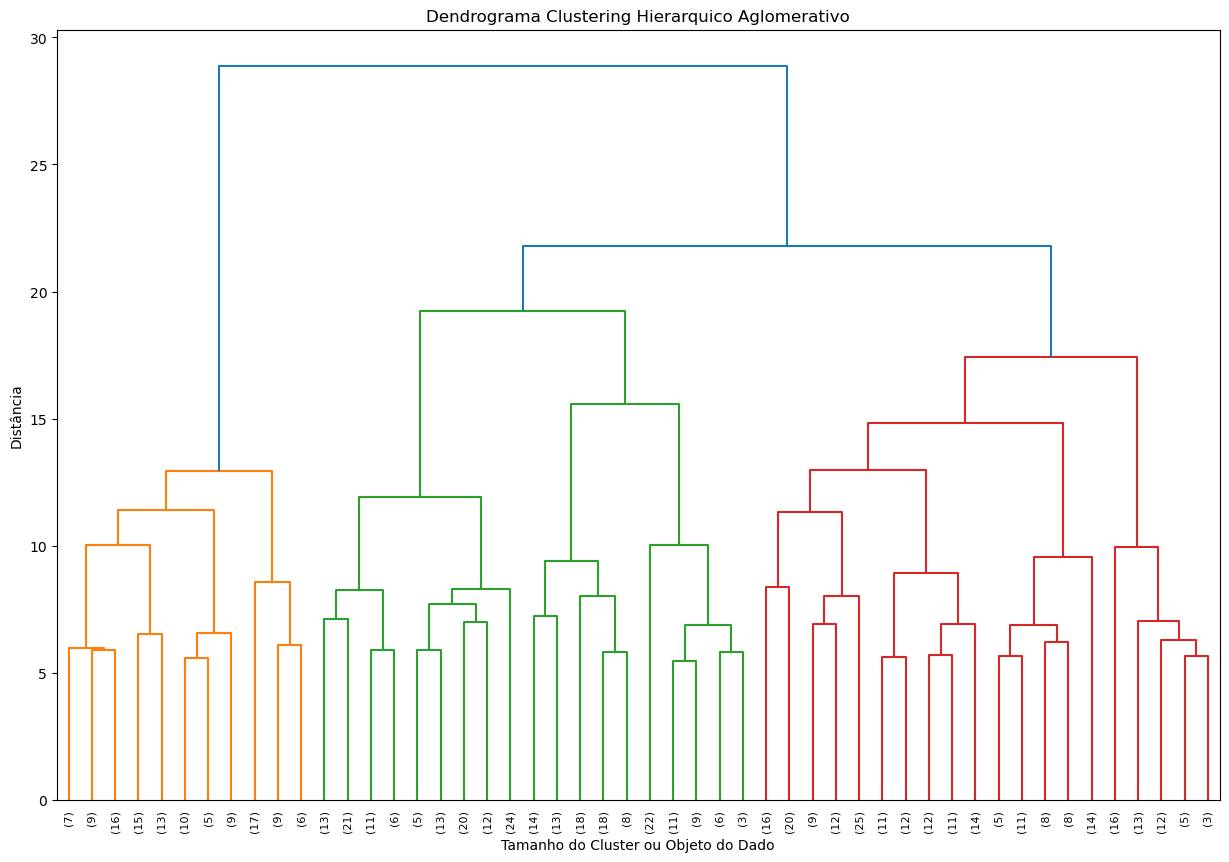

In [27]:
plt.figure(figsize=(15,10))
plt.title("Hierarchical Clustering Dendrogram")
dendrogram(modelo_de, truncate_mode="lastp",p=50)
plt.title('Dendrograma Clustering Hierarquico Aglomerativo')
plt.xlabel('Tamanho do Cluster ou Objeto do Dado')
plt.ylabel('Distância')
plt.show()

In [28]:
# Teste diferentes alturas para encontrar a que dá ~10 clusters
for height in [5, 7, 10, 12]:
    clusters = cut_tree(modelo_de, height=height)
    n_clusters = len(np.unique(clusters))
    print(f"Height={height}: {n_clusters} clusters")

Height=5: 58 clusters
Height=7: 29 clusters
Height=10: 14 clusters
Height=12: 9 clusters


In [29]:
clusters_de_scipy = cut_tree(modelo_de, height=10)
len(np.unique(clusters_de_scipy))

14

In [30]:
px.scatter(df_species,x='body_mass_kg',y='diet_type', color='cluster')

In [31]:
df_species.head()

,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior,cluster
0,59,6,1,27,carnivore,2,fur,0,118,0,pair-living,7
1,47,6,1,25,carnivore,4,fur,0,121,0,solitary,4
2,62,8,1,50,carnivore,2,fur,0,119,0,pair-living,0
3,80,2,1,46,carnivore,4,fur,1,121,0,solitary,10
4,45,4,0,40,herbivore,2,scales,0,120,0,group-living,2


In [33]:
print("=" * 60)
print("ANÁLISE DESCRITIVA DOS CLUSTERS")
print("=" * 60)

for cluster_id in sorted(df_species['cluster'].unique()):
    cluster_data = df_species[df_species['cluster'] == cluster_id]
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}")
    print(f"Tamanho: {len(cluster_data)} espécies")
    print(f"{'='*60}")
    
    print("\n📊 CARACTERÍSTICAS NUMÉRICAS (Média):")
    numeric_cols = ['body_mass_kg', 'num_legs', 'tail_length_cm', 
                    'eye_count', 'avg_lifespan_years']
    for col in numeric_cols:
        print(f"  {col}: {cluster_data[col].mean():.2f}")
    
    print("\n🏷️ CARACTERÍSTICAS CATEGÓRICAS (Moda):")
    categorical_cols = ['diet_type', 'skin_type', 'social_behavior']
    for col in categorical_cols:
        mode_value = cluster_data[col].mode()[0] if len(cluster_data[col].mode()) > 0 else 'N/A'
        percentage = (cluster_data[col] == mode_value).sum() / len(cluster_data) * 100
        print(f"  {col}: {mode_value} ({percentage:.1f}%)")
    
    print("\n✅ CARACTERÍSTICAS BINÁRIAS:")
    binary_cols = ['has_wings', 'nocturnal', 'has_venom']
    for col in binary_cols:
        percentage = cluster_data[col].mean() * 100
        print(f"  {col}: {percentage:.1f}% das espécies")

ANÁLISE DESCRITIVA DOS CLUSTERS

CLUSTER 0
Tamanho: 46 espécies

📊 CARACTERÍSTICAS NUMÉRICAS (Média):
  body_mass_kg: 64.63
  num_legs: 6.61
  tail_length_cm: 51.98
  eye_count: 1.78
  avg_lifespan_years: 119.43

🏷️ CARACTERÍSTICAS CATEGÓRICAS (Moda):
  diet_type: carnivore (60.9%)
  skin_type: fur (28.3%)
  social_behavior: solitary (43.5%)

✅ CARACTERÍSTICAS BINÁRIAS:
  has_wings: 32.6% das espécies
  nocturnal: 37.0% das espécies
  has_venom: 17.4% das espécies

CLUSTER 1
Tamanho: 60 espécies

📊 CARACTERÍSTICAS NUMÉRICAS (Média):
  body_mass_kg: 53.73
  num_legs: 2.60
  tail_length_cm: 49.27
  eye_count: 2.00
  avg_lifespan_years: 118.98

🏷️ CARACTERÍSTICAS CATEGÓRICAS (Moda):
  diet_type: omnivore (70.0%)
  skin_type: feathers (45.0%)
  social_behavior: pair-living (73.3%)

✅ CARACTERÍSTICAS BINÁRIAS:
  has_wings: 25.0% das espécies
  nocturnal: 36.7% das espécies
  has_venom: 21.7% das espécies

CLUSTER 2
Tamanho: 71 espécies

📊 CARACTERÍSTICAS NUMÉRICAS (Média):
  body_mass_kg: 4